# 08 — Interpretabilidad del Modelo

**Objetivo:** Entender cómo y por qué el modelo de primas (`stacking_ensemble`) 
toma sus decisiones, usando:

- Importancia global de variables (Permutation Importance).
- Gráficos PDP / ICE para relaciones feature → predicción.
- Explicaciones locales con **SHAP** y **LIME**.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.metrics import make_scorer

import shap
import lime.lime_tabular

import joblib

sys.path.append("..")

import src.train as train
StackingEnsemble = train.StackingEnsemble

from src.config import FEAST_TRAINSET, TARGET, MODELS_DIR
from src.data import split_xy
from src.logging_utils import setup_logger

2025-11-16 17:45:31.460 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: /home/fernando/Documentos/insurance-mlops


In [2]:
logger = setup_logger("interpretability")
logger.info("Notebook 08_Interpretabilidad iniciado.")

2025-11-16 17:45:32.155 | INFO     | __main__:<module>:2 - Notebook 08_Interpretabilidad iniciado.
2025-11-16 17:45:32 | INFO | Notebook 08_Interpretabilidad iniciado.


In [3]:
# Rutas
TRAIN_PATH = Path("..") / FEAST_TRAINSET      # data/feast/training_set.parquet
MODEL_PATH = MODELS_DIR / "stacking_ensemble.joblib"

logger.info(f"Cargando training set desde: {TRAIN_PATH}")
df_train = pd.read_parquet(TRAIN_PATH)

logger.info(f"Shape training: {df_train.shape}")

# Separar X, y
X, y = split_xy(df_train)
logger.info(f"Shape X: {X.shape}, y: {y.shape}")

# Cargar el modelo ensamblado
logger.info(f"Cargando modelo de stacking desde: {MODEL_PATH}")
ensemble_model = joblib.load(MODEL_PATH)

# (opcional) chequear que predice
y_pred_sample = ensemble_model.predict(X.iloc[:100])
logger.info(f"Predicciones de prueba OK. Ejemplo: {y_pred_sample[:5]}")

2025-11-16 17:45:32.174 | INFO     | __main__:<module>:5 - Cargando training set desde: ../data/feast/training_set.parquet
2025-11-16 17:45:32 | INFO | Cargando training set desde: ../data/feast/training_set.parquet
2025-11-16 17:45:32.269 | INFO     | __main__:<module>:8 - Shape training: (1200000, 39)
2025-11-16 17:45:32 | INFO | Shape training: (1200000, 39)
2025-11-16 17:45:32.298 | INFO     | __main__:<module>:12 - Shape X: (1200000, 36), y: (1200000,)
2025-11-16 17:45:32 | INFO | Shape X: (1200000, 36), y: (1200000,)
2025-11-16 17:45:32.298 | INFO     | __main__:<module>:15 - Cargando modelo de stacking desde: /home/fernando/Documentos/insurance-mlops/models/stacking_ensemble.joblib
2025-11-16 17:45:32 | INFO | Cargando modelo de stacking desde: /home/fernando/Documentos/insurance-mlops/models/stacking_ensemble.joblib
2025-11-16 17:45:32.583 | INFO     | __main__:<module>:20 - Predicciones de prueba OK. Ejemplo: [1025.71726792 1590.88330275 1162.03105674 1204.09298731 1354.735194

In [4]:
df_train.shape

(1200000, 39)

In [5]:
# Muestra aleatoria para interpretabilidad (global y local)
RANDOM_STATE = 42
N_SAMPLE = 50_000

if len(X) > N_SAMPLE:
    X_sample = X.sample(N_SAMPLE, random_state=RANDOM_STATE)
    y_sample = y.loc[X_sample.index]
else:
    X_sample = X.copy()
    y_sample = y.copy()

logger.info(f"Usando muestra de tamaño: {X_sample.shape}")

2025-11-16 17:45:32.652 | INFO     | __main__:<module>:12 - Usando muestra de tamaño: (50000, 36)
2025-11-16 17:45:32 | INFO | Usando muestra de tamaño: (50000, 36)


In [6]:
from src.models import rmsle
from sklearn.metrics import make_scorer

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [7]:
from sklearn.base import BaseEstimator

class StackingWrapper(BaseEstimator):
    def __init__(self, model):
        # ensemble_model ya entrenado (StackingEnsemble)
        self.model = model

    # sklearn usará este método para saber si el modelo está "fitted". Es solo una ayuda
    def fit(self):
        return self

    def predict(self, X):
        return self.model.predict(X)

In [8]:
wrapped_model = StackingWrapper(ensemble_model)

In [9]:
logger.info("Calculando Permutation Importance global (RMSLE)...")

result = permutation_importance(
    estimator=wrapped_model,
    X=X_sample,
    y=y_sample,
    scoring=rmsle_scorer,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

importances_mean = result.importances_mean
importances_std = result.importances_std

feat_importance = (
    pd.DataFrame(
        {
            "feature": X_sample.columns,
            "importance_mean": importances_mean,
            "importance_std": importances_std,
        }
    )
    .sort_values("importance_mean", ascending=True)  # scorer negativo, más negativo = más importante
)

feat_importance.tail(20)

2025-11-16 17:45:32.724 | INFO     | __main__:<module>:1 - Calculando Permutation Importance global (RMSLE)...
2025-11-16 17:45:32 | INFO | Calculando Permutation Importance global (RMSLE)...


2025-11-16 17:45:34.538 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: /home/fernando/Documentos/insurance-mlops
2025-11-16 17:45:34.727 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: /home/fernando/Documentos/insurance-mlops
2025-11-16 17:45:34.747 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: /home/fernando/Documentos/insurance-mlops
2025-11-16 17:45:34.938 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: /home/fernando/Documentos/insurance-mlops
2025-11-16 17:45:35.107 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: /home/fernando/Documentos/insurance-mlops
2025-11-16 17:45:35.133 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: /home/fernando/Documentos/insurance-mlops
2025-11-16 17:45:35.354 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: /home/fernando/Documentos/insurance-mlops
2025-11-16 17:45:35.473 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: /home/fernando/Documentos/insurance-mlops
2025-11-16 17:45

,feature,importance_mean,importance_std
18,Smoking Status_Yes,0.000119,0.000007
20,Marital Status_Married,0.000141,0.000018
13,Policy Type,0.000236,0.000012
12,psd_month_cos,0.000282,0.000013
11,psd_month_sin,0.000331,0.000011
14,Education Level,0.000346,0.000016
25,Occupation_Unknown,0.000415,0.000087
9,psd_month,0.000423,0.000027
10,psd_dow,0.000444,0.000018
2,Number of Dependents,0.000539,0.000017


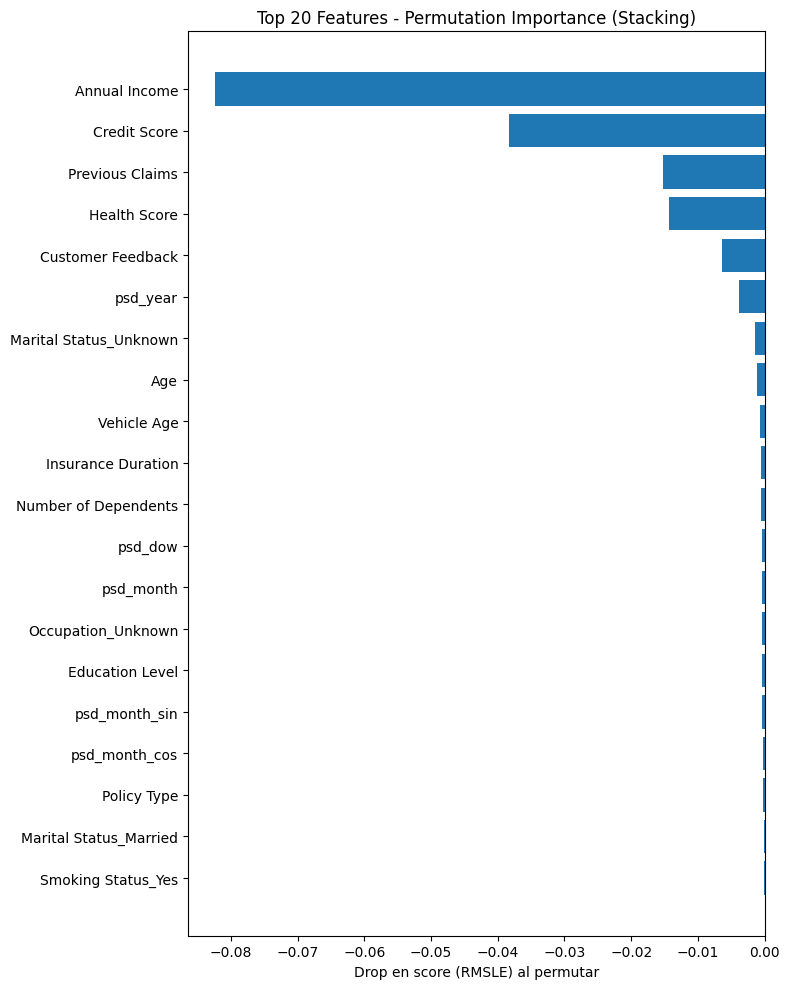

In [10]:
TOP_N = 20
top_feats = feat_importance.tail(TOP_N)

plt.figure(figsize=(8, 10))
plt.barh(top_feats["feature"], -top_feats["importance_mean"])  # ponemos positivo para interpretar
plt.xlabel("Drop en score (RMSLE) al permutar")
plt.title(f"Top {TOP_N} Features - Permutation Importance (Stacking)")
plt.tight_layout()
plt.show()

### 2. Conclusiones de importancia global (Permutation Importance)

A partir del **Permutation Importance** calculado sobre una muestra de 50 000 registros usando como métrica el RMSLE, se observa que:

- **Las variables económicas son las más influyentes en la predicción de la prima**:
  - `Annual Income` es, con diferencia, la característica con mayor importancia global (~0.082), lo que sugiere que el nivel de ingresos del cliente es un fuerte determinante del nivel de prima estimada.
  - `Credit Score` aparece como la segunda variable más importante (~0.038), indicando que el perfil de riesgo crediticio del cliente también tiene un impacto considerable en la prima.

- **El historial del cliente también juega un papel clave**:
  - `Previous Claims` y `Health Score` muestran importancias relativamente altas, lo que indica que el historial de siniestros y el estado de salud del cliente aportan información relevante para el modelo.

- **Aspectos de experiencia y relación con la aseguradora tienen relevancia moderada**:
  - `Customer Feedback`, `Insurance Duration` y `Vehicle Age` aportan señal al modelo, aunque en menor magnitud que las variables puramente económicas y de riesgo.

- **Las variables temporales del seguro aportan información adicional**:
  - Variables como `psd_year`, `psd_month`, `psd_dow`, `psd_month_sin` y `psd_month_cos` muestran que el momento en el que se contrata o renueva la póliza también afecta de forma no despreciable a la prima.

- **Las características sociodemográficas y de estilo de vida tienen efecto, pero más pequeño**:
  - `Age`, `Number of Dependents`, `Education Level`, `Marital Status_*` y `Smoking Status_Yes` tienen importancias positivas pero menores, indicando que el modelo las utiliza como variables complementarias más que como drivers principales.

En conjunto, el modelo se apoya principalmente en **capacidad económica (ingresos y score crediticio)** y **riesgo histórico (reclamos previos y salud)** para estimar la prima, mientras que la información temporal, sociodemográfica y de comportamiento refina la predicción pero con un peso menor.

## PDP + ICE (relaciones globales) usando HGB

In [11]:
hgb_model = ensemble_model.bases[0]
type(hgb_model)

sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingRegressor

In [12]:
# Features candidatas para PDP/ICE (basadas en la importancia global)
features_pdp = [
    "Annual Income",
    "Credit Score",
    "Previous Claims",
    "Health Score",
]

# Nos aseguramos de que existan en X_sample
features_pdp = [f for f in features_pdp if f in X_sample.columns]
logger.info(f"Features para PDP/ICE (presentes en X): {features_pdp}")

2025-11-16 17:48:01.590 | INFO     | __main__:<module>:11 - Features para PDP/ICE (presentes en X): ['Annual Income', 'Credit Score', 'Previous Claims', 'Health Score']
2025-11-16 17:48:01 | INFO | Features para PDP/ICE (presentes en X): ['Annual Income', 'Credit Score', 'Previous Claims', 'Health Score']


2025-11-16 17:48:01.610 | INFO     | __main__:<module>:4 - Features para PDP/ICE (presentes en X): ['Annual Income', 'Credit Score', 'Previous Claims', 'Health Score']
2025-11-16 17:48:01 | INFO | Features para PDP/ICE (presentes en X): ['Annual Income', 'Credit Score', 'Previous Claims', 'Health Score']


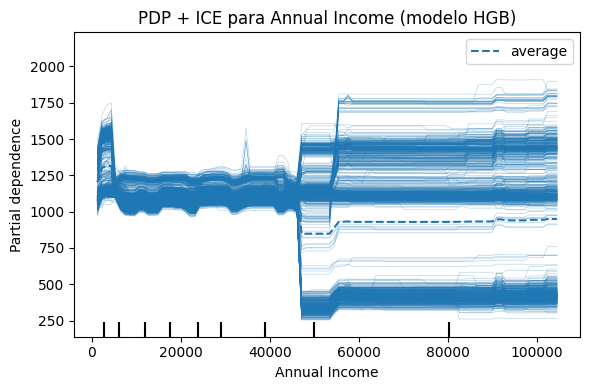

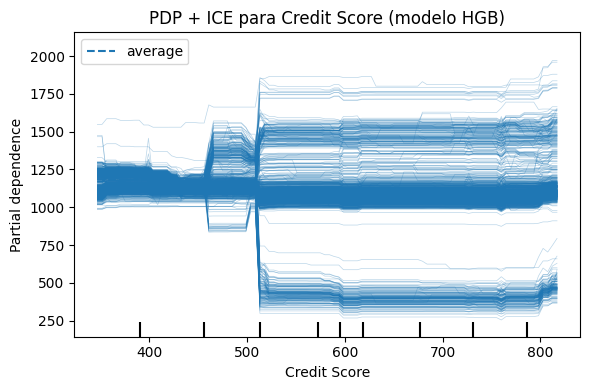

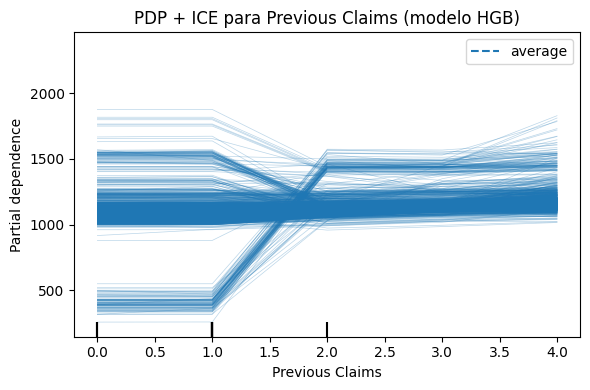

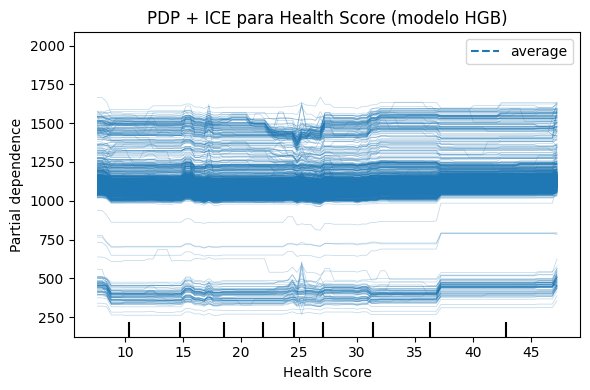

In [13]:
from sklearn.inspection import PartialDependenceDisplay

existing = [f for f in features_pdp if f in X_sample.columns]
logger.info(f"Features para PDP/ICE (presentes en X): {existing}")

for feat in existing:
    fig, ax = plt.subplots(figsize=(6, 4))
    PartialDependenceDisplay.from_estimator(
        estimator=hgb_model,
        X=X_sample,
        features=[feat],
        kind="both",   # PDP + ICE
        ax=ax,
    )
    plt.title(f"PDP + ICE para {feat} (modelo HGB)")
    plt.tight_layout()
    plt.show()

### 3. Interpretación de los PDP + ICE (modelo HGB)

Los gráficos PDP + ICE muestran el efecto **medio** de cada variable sobre la prima predicha (línea discontinua, PDP) y cómo se comportan casos individuales (curvas finas, ICE). El PDP resume la relación promedio entre la variable y la prima, mientras que la dispersión de las curvas ICE indica cuánta **heterogeneidad / interacción con otras variables** hay en esa zona del espacio de datos.   

#### Annual Income

- Para ingresos anuales bajos y medios (hasta aprox. 40–45k) la prima media se mantiene bastante **plana**, lo que indica que en ese rango el modelo no ajusta mucho la prima en función del ingreso.
- Alrededor de 45–55k aparece un **salto brusco**: la prima promedio cambia de nivel y las curvas ICE se separan en distintos “bloques”. Esto es típico de un modelo de árboles que ha aprendido umbrales claros en esa variable.
- Para ingresos altos la relación vuelve a ser relativamente estable, pero con varias bandas de ICE, lo que sugiere que el efecto del ingreso depende fuertemente de otras variables (por ejemplo, historial de siniestros o score de crédito).

En resumen, el ingreso no tiene un efecto lineal ni suave: el modelo aprende **umbrales** más que una pendiente continua.

#### Credit Score

- Para scores de crédito bajos, la prima se mantiene en un rango relativamente estrecho.
- En la zona de 480–520 hay otro **punto de quiebre**: muchas curvas ICE cambian de nivel y la prima media se ajusta de forma abrupta.
- A partir de scores más altos se observan varios “niveles” de prima (bandas horizontales), señal de que el score de crédito está interactuando con otras variables: para algunos perfiles, un score alto se traduce en primas más altas; para otros, en primas más bajas.

Esto indica que la relación **no es monótona** del tipo “a mejor crédito, menor prima”, sino que el modelo usa el score en combinación con otras variables para segmentar a los clientes.

#### Previous Claims

- La línea media muestra una relación mucho más **intuitiva y casi monótona**: al pasar de 0 a 1–2 siniestros previos, la prima promedio aumenta de forma clara.
- Las curvas ICE también suben al aumentar el número de siniestros, aunque con distinta pendiente según el cliente, lo que indica heterogeneidad pero con una tendencia general consistente: **más siniestros → prima más alta**.
- Para valores altos de siniestros el aumento se suaviza un poco, lo que sugiere que el modelo puede estar “saturando” el efecto (a partir de cierto número de siniestros ya todos son considerados muy riesgosos).

En conjunto, esta variable muestra el comportamiento más “esperable” para un modelo de primas.

#### Health Score

- El efecto del `Health Score` es más **suave**: la prima media varía, pero sin saltos tan pronunciados como en Income o Credit Score.
- Se observan varias bandas de ICE relativamente paralelas, lo que sugiere que en gran parte del rango el efecto es casi aditivo (mismo patrón para muchos individuos), aunque hay zonas con mayor dispersión.
- La dirección exacta del efecto (prima algo mayor o menor con mejores peores scores) depende de cómo esté definido el indicador de salud. En cualquier caso, el modelo parece usarlo como un ajuste fino sobre otros factores más fuertes (siniestros, ingreso, score de crédito).

#### Conclusiones generales

- **Income** y **Credit Score** presentan relaciones muy **no lineales**, con puntos de corte claros y fuerte interacción con otras variables (gran abanico de curvas ICE en ciertas zonas).
- **Previous Claims** muestra una relación **monótona y coherente con el negocio**, actuando como uno de los drivers principales de la prima.
- **Health Score** actúa como variable de ajuste, con efecto moderado y más suave.
- La diferencia entre la línea PDP (promedio) y las curvas ICE nos recuerda que el comportamiento medio puede **ocultar subgrupos** con dinámicas distintas, por lo que es importante mirar ambas vistas para entender de verdad la lógica del modelo.   

## SHAP sobre el HGB (global + local)

In [14]:
import shap

shap.initjs()  # para gráficos interactivos en notebook
logger.info("Entrenando SHAP TreeExplainer sobre HGB...")

X_shap = X_sample.copy()

explainer = shap.TreeExplainer(hgb_model)
shap_values = explainer.shap_values(X_shap)
expected_value = explainer.expected_value

2025-11-16 17:48:24.180 | INFO     | __main__:<module>:4 - Entrenando SHAP TreeExplainer sobre HGB...
2025-11-16 17:48:24 | INFO | Entrenando SHAP TreeExplainer sobre HGB...


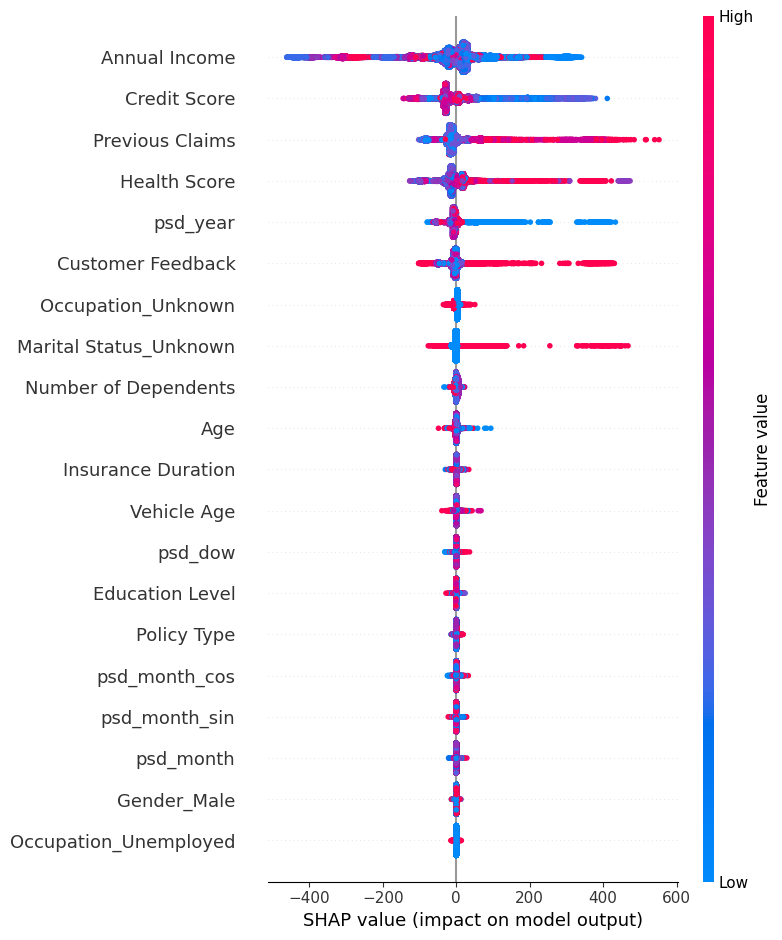

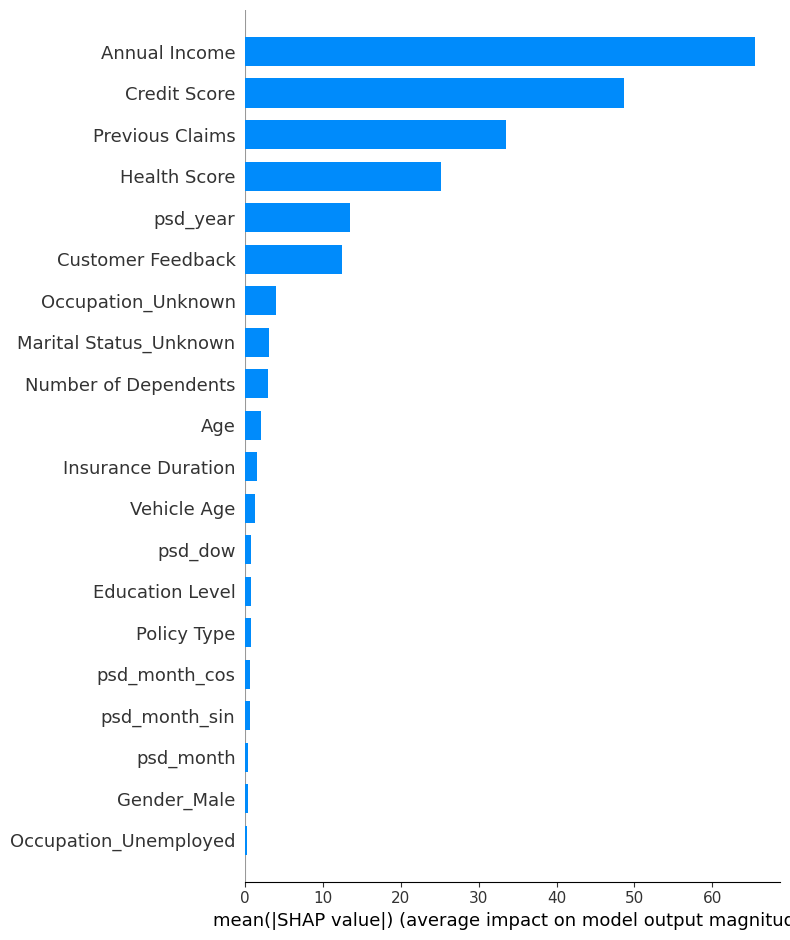

In [15]:
# Scatter tipo "beeswarm"
shap.summary_plot(shap_values, X_shap, plot_type="dot")

# Importancia promedio absoluta por variable
shap.summary_plot(shap_values, X_shap, plot_type="bar")

In [16]:
idx = X_shap.index[0]   # ejemplo
x_row = X_shap.loc[idx:idx]  # DataFrame de una sola fila

# shap_values es un array; necesitamos la fila correspondiente
row_pos = X_shap.index.get_loc(idx)
shap_row = shap_values[row_pos]

print("y_true:", y.loc[idx])
print("y_pred (HGB):", hgb_model.predict(x_row)[0])

y_true: 4264.0
y_pred (HGB): 1425.8684356911847


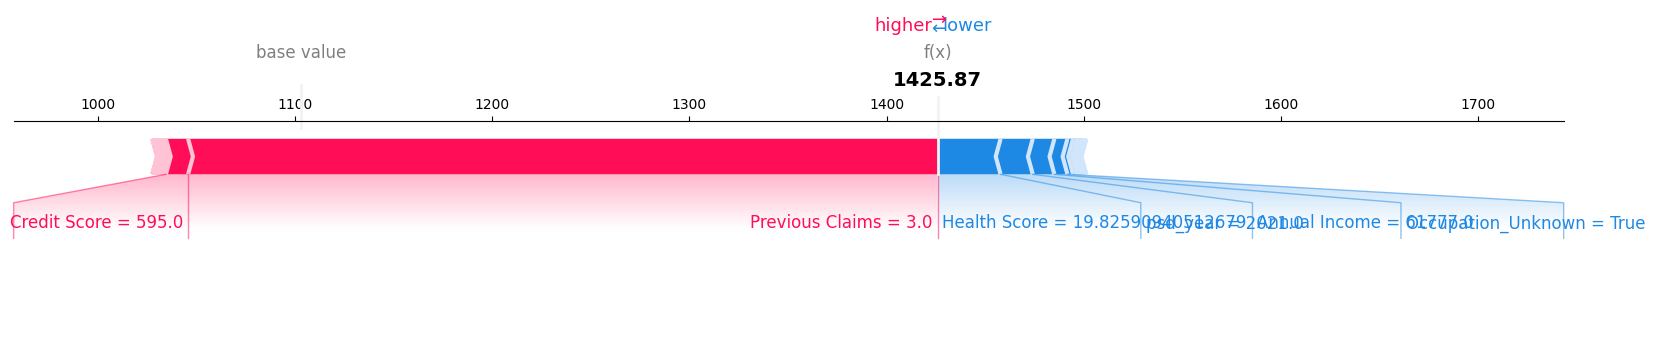

In [17]:
shap.force_plot(
    expected_value,
    shap_row,
    x_row,
    matplotlib=True
)

### 4. Interpretación de SHAP

A nivel **global**, los gráficos `summary_plot` confirman que:

- **Annual Income**, **Credit Score**, **Previous Claims** y **Health Score** son las variables que más contribuyen a la variación de la prima predicha.
- La mezcla de puntos rojos (valores altos) y azules (valores bajos) a ambos lados de cero indica que estas variables no tienen un efecto lineal simple: según el perfil del cliente pueden **aumentar o reducir** la prima, lo que concuerda con los umbrales y segmentaciones que se veían en los PDP/ICE (el modelo usa estos atributos para partir el espacio en grupos de riesgo distintos).   

En el análisis **local** del cliente elegido (gráfico `force_plot`):

- La prima base del modelo (valor medio) se sitúa alrededor de 1 100 unidades, y para este cliente se ajusta hasta ≈ **1 426**.
- El **Credit Score** y el número de **Previous Claims** aparecen como los principales factores que **empujan la prima hacia arriba** (barras rosas grandes).
- Otras características del perfil (como Annual Income, Health Score, variables de ocupación/estado civil) tienen efectos compensatorios que **reducen parcialmente** la prima (barras azules), pero no lo suficiente como para volver al nivel base.

En conjunto, SHAP refuerza la idea de que el modelo está usando principalmente **ingresos, score crediticio y siniestralidad previa** como motores de riesgo, y que para un cliente concreto podemos descomponer de forma transparente cuánto aporta cada factor a la prima estimada.